# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import random
from collections import namedtuple, deque
import copy
import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt



In [2]:

def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    
    return (-lim, lim)

class Actor(nn.Module):

    def __init__(self, state_size, action_size, seed=0, hidden_units_1=256, hidden_units_2=128):

        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, hidden_units_1)
        self.fc2 = nn.Linear(hidden_units_1, hidden_units_2)
        self.fc3 = nn.Linear(hidden_units_2, action_size)
        self.bn1 = nn.BatchNorm1d(hidden_units_1)
        self.bn2 = nn.BatchNorm1d(hidden_units_2)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        if state.dim() == 1:
            state = torch.unsqueeze(state,0)
        x = F.relu(self.fc1(state))
        x = self.bn1(x)
        x = F.relu(self.fc2(x))
        return torch.tanh(self.fc3(x))

class Critic(nn.Module):

    def __init__(self, full_state_size, actions_size, seed=0, hidden_units_1=256, hidden_units_2=128):

        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        
        self.fcs1 = nn.Linear(full_state_size, hidden_units_1)
        self.fc2 = nn.Linear(hidden_units_1+actions_size, hidden_units_2)
        self.fc3 = nn.Linear(hidden_units_2, 1)
        
        self.bn1 = nn.BatchNorm1d(hidden_units_1)
        self.bn2 = nn.BatchNorm1d(hidden_units_2)
        
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):

        xs = F.relu(self.fcs1(state))
        xs = self.bn1(xs)
        
        x = torch.cat((xs, action), dim=1)
        x = F.relu(self.fc2(x))
        
        return self.fc3(x)

In [3]:
class Agent:
    
    def __init__(self, state_size, action_size, num_agents, random_seed):

        self.state_size = state_size
        self.action_size = action_size
        
        self.seed = random.seed(random_seed)

        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        self.critic_local = Critic(state_size*num_agents, action_size*num_agents, random_seed).to(device)
        self.critic_target = Critic(state_size*num_agents, action_size*num_agents, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        self.soft_update(self.critic_local, self.critic_target, 1)
        self.soft_update(self.actor_local, self.actor_target, 1)    
        
        self.noise = 0 #OUNoise(action_size, random_seed)
        self.noise_reduction_ratio = NOISE_START

        self.step_count = 0

    def act(self, state, i_episode, add_noise=True):

        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        
        if add_noise:
            if i_episode > EPISODES_BEFORE_TRAINING and self.noise_reduction_ratio > NOISE_END:
                
                self.noise_reduction_ratio = NOISE_REDUCTION_RATE**(i_episode-EPISODES_BEFORE_TRAINING)
                
            action += self.noise_reduction_ratio * self.add_noise_random()
            
        return np.clip(action, -1, 1)

    def add_noise_random(self):
        noise = 0.5*np.random.standard_normal(self.action_size)
        return noise
    

    def learn(self, experiences, gamma):

        full_states, actions, actor_local_actions, actor_target_actions, agent_state, agent_action, agent_reward, agent_done, next_states, next_full_states = experiences

        Q_targets_next = self.critic_target(next_full_states, actor_target_actions)
        Q_targets = agent_reward + (gamma * Q_targets_next * (1 - agent_done))

        Q_expected = self.critic_local(full_states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)

        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()


        actor_loss = -self.critic_local(full_states, actor_local_actions).mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
                   
            
    def soft_update(self, local_model, target_model, tau):

        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)



In [4]:

class MADDPG:
    
    def __init__(self, state_size, action_size, num_agents, random_seed):
        
        self.state_size = state_size
        self.action_size = action_size
        self.random_seed = random.seed(random_seed)
        
        self.agents = [Agent(state_size, action_size, num_agents, random_seed) for i in range(num_agents)]
        
        self.memory = ReplayBuffer(BUFFER_SIZE, BATCH_SIZE, random_seed)
        
        self.step_count = 0
        
            

    def act(self, state, i_episode, add_noise=True):
        
        actions = []
        for agent_state, agent in zip(state, self.agents):
            action = agent.act(agent_state, i_episode, add_noise)
            action = np.reshape(action, newshape=(-1))
            actions.append(action)
        
        actions = np.stack(actions)
        
        return actions

    
    def step(self, i_episode, state, action, reward, next_state, done):
        
        full_state = np.reshape(state, newshape=(-1))
        next_full_state = np.reshape(next_state, newshape=(-1))
        
        self.memory.add(state, full_state, action, reward, next_state, next_full_state, done)
        
        self.step_count = ( self.step_count + 1 ) % UPDATE_FREQ
        
        if (len(self.memory) > BATCH_SIZE) & (i_episode > EPISODES_BEFORE_TRAINING):
            for l_cnt in range(3):
                for agent in self.agents:
                    experiences = self.memory.sample()
                    self.learn(experiences, agent, GAMMA)

                for agent in self.agents:
                    agent.soft_update(agent.actor_local, agent.actor_target, TAU)
                    agent.soft_update(agent.critic_local, agent.critic_target, TAU)

    def learn(self, experiences, agent, GAMMA):
        
        states, full_states, actions, rewards, next_states, next_full_states, dones = experiences        

        actor_target_actions = torch.zeros(actions.shape, dtype=torch.float, device=device)
        
        for agent_idx, agent_i in enumerate(self.agents):
            if agent == agent_i:
                agent_id = agent_idx
            agent_i_current_state = states[:,agent_idx]
            actor_target_actions[:,agent_idx,:] = agent_i.actor_target.forward(agent_i_current_state)
            
        actor_target_actions = actor_target_actions.view(BATCH_SIZE, -1)

        agent_state = states[:,agent_id,:]
        agent_action = actions[:,agent_id,:]
        agent_reward = rewards[:,agent_id].view(-1,1)
        agent_done = dones[:,agent_id].view(-1,1)
        
        
        actor_local_actions = actions.clone()
        actor_local_actions[:, agent_id, :] = agent.actor_local.forward(agent_state)
        actor_local_actions = actor_local_actions.view(BATCH_SIZE, -1)
        

        actions = actions.view(BATCH_SIZE, -1)

        
        agent_experience = (full_states, actions, actor_local_actions, actor_target_actions,
                            agent_state, agent_action, agent_reward, agent_done,
                            next_states, next_full_states)

        agent.learn(agent_experience, GAMMA)
        
        
class ReplayBuffer(object):

    def __init__(self, buffer_size, batch_size, seed):

        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=['state', 'full_state', 'action', 'reward', 'next_state', 'next_full_state','done'])
        self.seed = random.seed(seed)
    
    def add(self, state, full_state, action, reward, next_state, next_full_state, done):
        e = self.experience(state, full_state, action, reward, next_state, next_full_state, done)
        self.memory.append(e)
    
    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)
        
        states = torch.from_numpy(np.array([e.state for e in experiences if e is not None])).float().to(device)
        full_states = torch.from_numpy(np.array([e.full_state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.array([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.array([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.array([e.next_state for e in experiences if e is not None])).float().to(device)
        next_full_states = torch.from_numpy(np.array([e.next_full_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.array([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, full_states, actions, rewards, next_states, next_full_states, dones)

    def __len__(self):
        return len(self.memory)    

In [5]:


def maddpg_train(n_episodes):
    # Initialize a deque to store the most recent 100 scores
    scores_deque = deque(maxlen=100)
    
    # Initialize lists to store historical maximum and mean scores
    scores_max_hist = []
    scores_mean_hist = []
    
    # Set environment solved flag to False initially
    env_solved = False
    stop_count = 0
    
    # Iterate through episodes for training
    for i_episode in range(n_episodes):
        
        # Reset the environment for each episode
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations
        scores = np.zeros(num_agents)
        
        step = 0
        
        # Execute actions and collect experiences until the episode is done
        while True:
            step += 1
            
            # Get actions for the current state from the MADDPG model
            action = maddpg.act(state, i_episode, add_noise=True)
            env_info = env.step(action)[brain_name]
            
            # Obtain the next state, reward, and done flag from the environment
            next_state = env_info.vector_observations
            reward = env_info.rewards
            done = env_info.local_done
            
            # Update the scores
            scores += reward
            
            # Perform a learning step for the MADDPG model
            maddpg.step(i_episode, state, action, reward, next_state, done)
            
            # Terminate the episode if any agent is done
            if np.any(done):
                break
            
            # Update the current state
            state = next_state
        
        # Calculate and store the maximum and mean scores
        score_max = np.max(scores)
        scores_deque.append(score_max)
        score_mean = np.mean(scores_deque)
        
        scores_max_hist.append(score_max)
        scores_mean_hist.append(score_mean)

        
        # Stop logic
        if env_solved == False and score_mean >= 0.5:
            stop_count+=1
            
        if stop_count >= 100:
            print(f'{i_episode} episode, average score {np.mean(scores_deque)} max score {score_max}')
            return scores_max_hist, scores_mean_hist
        
        # Check if the environment is solved and save the trained agents
        if env_solved == False and score_mean >= 0.5:
              
            print('\nEnvironment solved after {} episodes with the average score {}\n'.format(i_episode, score_mean))
            for idx, agent in enumerate(maddpg.agents):
                torch.save(agent.actor_local.state_dict(), f'agent{idx}_actor.pth')
                torch.save(agent.critic_local.state_dict(), f'critic{idx}_critic.pth')
            env_solved = True
            
            print('agents saved!')

        if i_episode % 100 == 0:
            print(f'{i_episode} episode, average score {np.mean(scores_deque)} max score {score_max}')
        
    return scores_max_hist, scores_mean_hist
    
    

In [6]:
# Initialize Unity environment for the Tennis app
env = UnityEnvironment(file_name="Tennis.app")

# Get the brain name and brain from the environment
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# Set hyperparameters for the reinforcement learning model
BUFFER_SIZE = int(1e5)  
BATCH_SIZE = 256        
UPDATE_FREQ = 1

GAMMA = 0.99            
TAU = 1e-3

LR_ACTOR = 1e-4         
LR_CRITIC = 3e-4        
WEIGHT_DECAY = 0        

# Noise parameters for exploration
NOISE_REDUCTION_RATE = 0.99
EPISODES_BEFORE_TRAINING = 500
NOISE_START=1.0
NOISE_END=0.1


# Set the device for PyTorch computations
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



# Reset the environment and obtain initial information
env_info = env.reset(train_mode=True)[brain_name]
num_agents = len(env_info.agents)
action_size = brain.vector_action_space_size
states = env_info.vector_observations
state_size = states.shape[1]


# Initialize the MADDPG multi-agent model
maddpg = MADDPG(state_size=state_size, action_size=action_size, num_agents=num_agents, random_seed=17)

# Train the MADDPG model and collect historical scores
historical_max_scores, historical_mean_scores = maddpg_train(n_episodes=1800)


env.close()

Mono path[0] = '/Users/cassimiro/code/projects/Multi-Agent-Tennis-Unity/RL-Multi-Agent-Tennis-Unity/Tennis.app/Contents/Resources/Data/Managed'
Mono config path = '/Users/cassimiro/code/projects/Multi-Agent-Tennis-Unity/RL-Multi-Agent-Tennis-Unity/Tennis.app/Contents/MonoBleedingEdge/etc'


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


0 episode, average score 0.0 max score 0.0
100 episode, average score 0.009600000157952308 max score 0.0
200 episode, average score 0.02170000035315752 max score 0.10000000149011612
300 episode, average score 0.010900000166147948 max score 0.0
400 episode, average score 0.013300000224262476 max score 0.0
500 episode, average score 0.018200000319629907 max score 0.09000000357627869
600 episode, average score 0.0010000000149011613 max score 0.0
700 episode, average score 0.0010000000149011613 max score 0.10000000149011612
800 episode, average score 0.004700000081211329 max score 0.0
900 episode, average score 0.014400000236928463 max score 0.09000000171363354
1000 episode, average score 0.06100000102072954 max score 0.0
1100 episode, average score 0.060700001027435065 max score 0.10000000149011612
1200 episode, average score 0.05750000096857548 max score 0.09000000171363354
1300 episode, average score 0.09910000158473849 max score 0.10000000149011612
1400 episode, average score 0.1453000

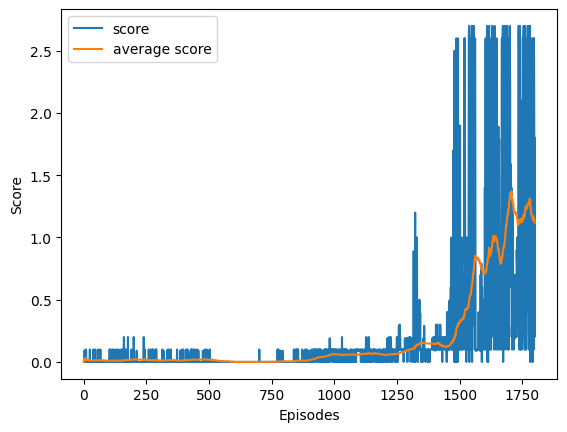

In [13]:
# Plot the historical maximum and average scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(historical_max_scores)+1), historical_max_scores, label='score')
plt.plot(np.arange(1, len(historical_mean_scores)+1), historical_mean_scores, label='average score')
plt.ylabel('Score')
plt.xlabel('Episodes')
plt.legend(loc='upper left')
plt.savefig('score.png',transparent=True)
plt.show()

In [12]:
env.close()